In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from tqdm import tqdm
from matplotlib import animation
from matplotlib.animation import PillowWriter

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
plt.rcParams['figure.figsize'] = [8 , 8]

# Extract Data

In [2]:
theta = 0.5
eps = 0.02

M = 1        
R = 1        
rho = 3*M/(4*np.pi*R**3)

## Old

In [3]:
#data = pandas.read_csv('./sphere_10k.out', sep='\s+', names=('A', 'B', 'C'), engine='python')
#data = data.to_numpy(dtype=float).ravel()
#data = data[np.isfinite(data)]
#
#N = int(data[0])
#time = data[2::(3+7*N)]
#x = np.zeros(N*len(time))
#y = np.zeros(N*len(time))
#z = np.zeros(N*len(time))
#vx = np.zeros(N*len(time))
#vy = np.zeros(N*len(time))
#vz = np.zeros(N*len(time))
#
#for i in tqdm(range(len(time))):
#    start = i*(3+7*N) + (3+N)
#    end = start + (6*N)
#    temp = data[start:end]
#    x[(i*N):((i+1)*N)] = temp[:3*N][::3].copy()
#    y[i*N:(i+1)*N] = temp[:3*N][1::3].copy()
#    z[i*N:(i+1)*N] = temp[:3*N][2::3].copy()
#    vx[i*N:(i+1)*N] = temp[3*N:][::3].copy()
#    vy[i*N:(i+1)*N] = temp[3*N:][1::3].copy()
#    vz[i*N:(i+1)*N] = temp[3*N:][2::3].copy()
#    
#data = []
#
#x = x.reshape(len(time), N).T
#y = y.reshape(len(time), N).T
#z = z.reshape(len(time), N).T
#vx = vx.reshape(len(time), N).T
#vy = vy.reshape(len(time), N).T
#vz = vz.reshape(len(time), N).T

## New

In [3]:
file = open('./sphere_100k_0.3.out', 'r')

N = int(file.readline())
time = []
x = []
y = []
z = []
vx = []
vy = []
vz = []

step = 3 + 3*N
i = 1
j = 0

while(True):   
    line = file.readline()
    
    if line=='':
        file.close()
        break
    
    i += 1
    
    k = i-j*step
    if (k==3): time.append(float(line))
    elif (k > 3+N and k <= 3+2*N): 
        line = [float(x) for x in line.split()]
        x.append(line[0])
        y.append(line[1])
        z.append(line[2])
    elif (k > 3+2*N and k <= 3+3*N):
        line = [float(x) for x in line.split()]
        vx.append(line[0])
        vy.append(line[1])
        vz.append(line[2])
        
    if i%step==0: j += 1
    

In [5]:
time = np.array(time)
x = np.array(x).reshape(len(time), N).T
y = np.array(y).reshape(len(time), N).T
z = np.array(z).reshape(len(time), N).T
vx = np.array(vx).reshape(len(time), N).T
vy = np.array(vy).reshape(len(time), N).T
vz = np.array(vz).reshape(len(time), N).T

In [ ]:
#time = np.load('numpy_arrays/time_100k.npy')
#x = np.load('numpy_arrays/x_100k.npy')
#y = np.load('numpy_arrays/y_100k.npy')
#z = np.load('numpy_arrays/z_100k.npy')
#vx = np.load('numpy_arrays/vx_100k.npy')
#vy = np.load('numpy_arrays/vy_100k.npy')
#vz = np.load('numpy_arrays/vz_100k.npy')
#N = int(len(x[:,0]))

# Compute T_collapse

In [8]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist = np.zeros(len(time))

#for i in tqdm(range(len(x[:, 0]))):
#    for j in range(len(x[:, 0])):
#        dist = dist + Dist(x[i, :], y[i, :], z[i], x[j], y[j], z[j])
#dist = dist/2 # We are counting each distance twice (since we want to find the minimum, it doens't even matter)

for i in tqdm(range(len(x[:, 0]))):
    dist = dist + Dist(x[i, :], y[i, :], z[i], 0, 0, 0)

100%|██████████| 100000/100000 [00:11<00:00, 8843.26it/s]


In [9]:
T_collapse = time[np.argsort(dist)[0]]
T_collapse

1.1149961

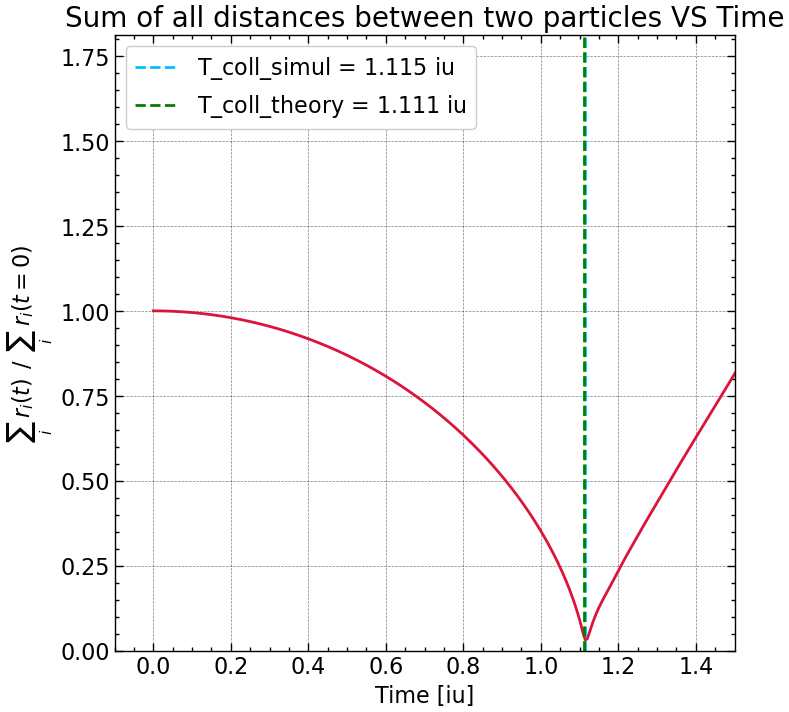

In [10]:
T_collapse_theory = np.sqrt((3*np.pi)/(32*rho))

plt.plot(time, dist/dist[0], color='crimson')
plt.axvline(T_collapse, ls='--', color='deepskyblue', label=f'T_coll_simul = ${T_collapse:.3f}$ iu')
plt.axvline(T_collapse_theory, ls='--', color='green', label=f'T_coll_theory = ${T_collapse_theory:.3f}$ iu')
plt.title('Sum of all distances between two particles VS Time', fontsize=20)
plt.xlabel('Time [iu]')
plt.ylabel('$\sum_i \: r_i(t) \:\: / \:\: \sum_i \: r_i(t=0)$')
plt.xlim(right=1.5)
plt.ylim(0)
plt.legend();

# Time VS Distance

$$\int_{0}^{t} \dot{r}\ddot{r} \,dt' = \int_{0}^{t} -\dfrac{GM(r)}{r^2}\dot{r} \,dt' \:\: \Longrightarrow \:\: t(r) = \sqrt{\dfrac{3}{8\pi G \rho_0}} \left[ \dfrac{\pi}{2} + \sqrt{\dfrac{r}{r_0}}\sqrt{1-\dfrac{r}{r_0}} - \arcsin{\left(\sqrt{\dfrac{r}{r_0}}\right)} \right]$$

In [11]:
def TimeVSdist(dist, rho):
    r_over_r0 = dist/dist[0]
    return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))

Let's compute the distance as a function of time of one particle

C:\Users\marco\AppData\Local\Temp\ipykernel_13052\2728156069.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))
C:\Users\marco\AppData\Local\Temp\ipykernel_13052\2728156069.py:3: RuntimeWarning: invalid value encountered in arcsin
  return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))


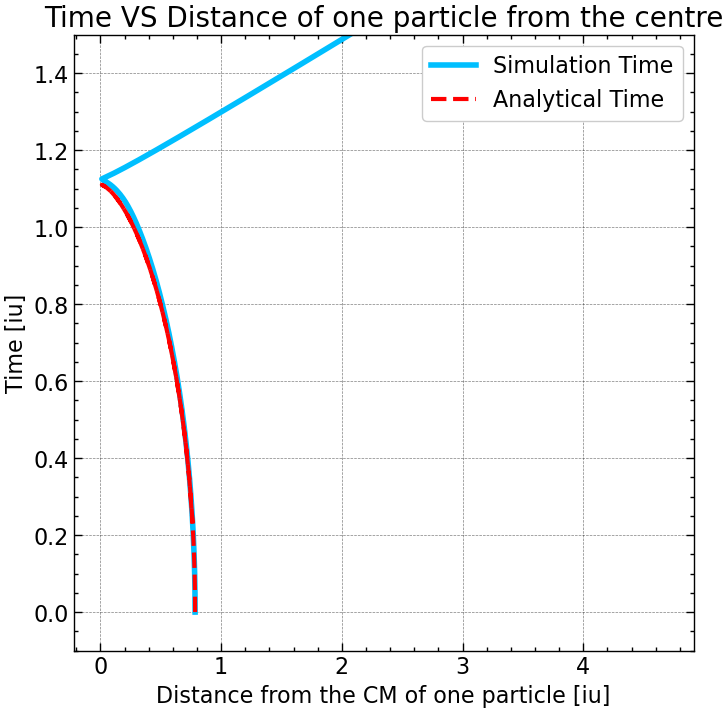

In [12]:
index = 4

dist_particle = Dist(x[index, :], y[index, :], z[index, :], 0, 0, 0)

plt.plot(dist_particle, time, label='Simulation Time', color='deepskyblue', lw=4)
plt.plot(dist_particle, TimeVSdist(dist_particle, rho), label='Analytical Time', ls='--', color='red', lw=3)
plt.title('Time VS Distance of one particle from the centre', fontsize=20)
plt.xlabel('Distance from the CM of one particle [iu]')
plt.ylabel('Time [iu]')
plt.ylim(top=1.5)
plt.legend()

100%|██████████| 100000/100000 [01:24<00:00, 1185.41it/s]
C:\Users\marco\AppData\Local\Temp\ipykernel_13052\2728156069.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))
C:\Users\marco\AppData\Local\Temp\ipykernel_13052\2728156069.py:3: RuntimeWarning: invalid value encountered in arcsin
  return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))


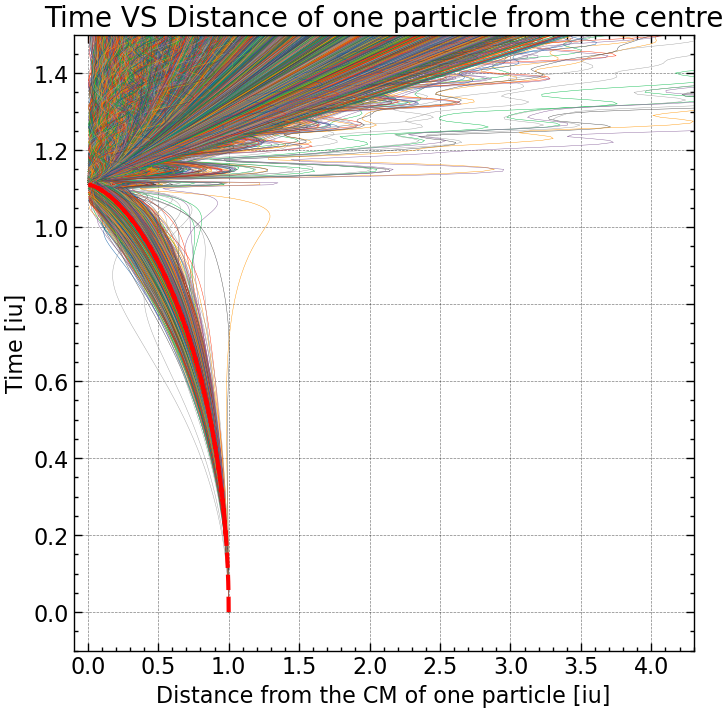

In [13]:
for i in tqdm(range(len(x[:,0]))):
    dist_particle = Dist(x[i, :], y[i, :], z[i, :], 0, 0, 0)
    plt.plot(dist_particle/dist_particle[0], time, lw=0.3)
plt.title('Time VS Distance of one particle from the centre', fontsize=20)
plt.xlabel('Distance from the CM of one particle [iu]')
plt.ylabel('Time [iu]')
plt.xlim(left=-0.1, right=4.3)
plt.ylim(top=1.5)

dist_particle = Dist(x[0, :], y[0, :], z[0, :], 0, 0, 0)
plt.plot(dist_particle/dist_particle[0], TimeVSdist(dist_particle, rho), ls='--', color='red', lw=3)

100%|██████████| 1000/1000 [00:01<00:00, 582.53it/s]
C:\Users\marco\AppData\Local\Temp\ipykernel_13052\2728156069.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))
C:\Users\marco\AppData\Local\Temp\ipykernel_13052\2728156069.py:3: RuntimeWarning: invalid value encountered in arcsin
  return np.sqrt(3/(8*np.pi*rho)) * (np.pi/2 + np.sqrt(r_over_r0)*np.sqrt(1 - r_over_r0) - np.arcsin(np.sqrt(r_over_r0)))


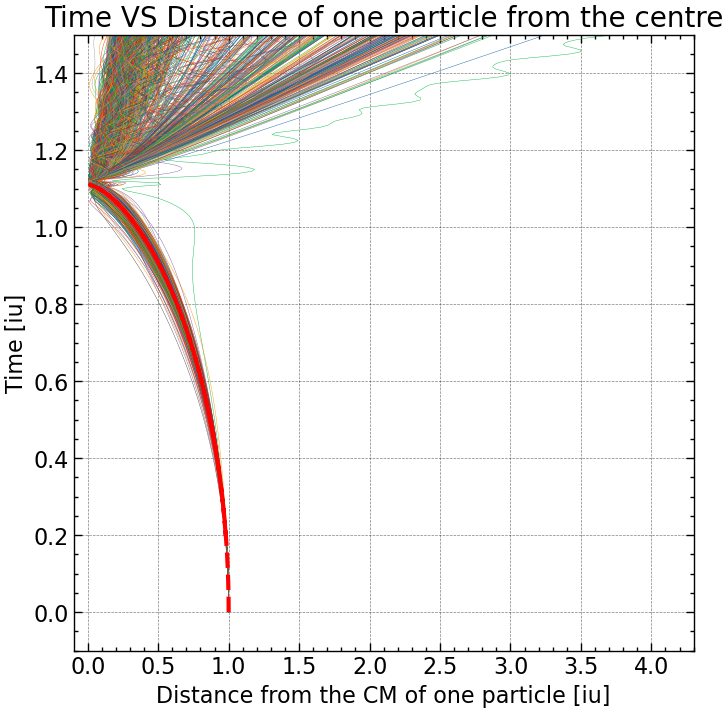

In [14]:
for i in tqdm(range(len(x[:1000,0]))):
    dist_particle = Dist(x[i, :], y[i, :], z[i, :], 0, 0, 0)
    plt.plot(dist_particle/dist_particle[0], time, lw=0.3)
plt.title('Time VS Distance of one particle from the centre', fontsize=20)
plt.xlabel('Distance from the CM of one particle [iu]')
plt.ylabel('Time [iu]')
plt.xlim(left=-0.1, right=4.3)
plt.ylim(top=1.5)

dist_particle = Dist(x[0, :], y[0, :], z[0, :], 0, 0, 0)
plt.plot(dist_particle/dist_particle[0], TimeVSdist(dist_particle, rho), ls='--', color='red', lw=3)

# Plot

In [17]:
markersize = 3
markeredgewidth = 0.15

Text(0.5, 0, 'z')

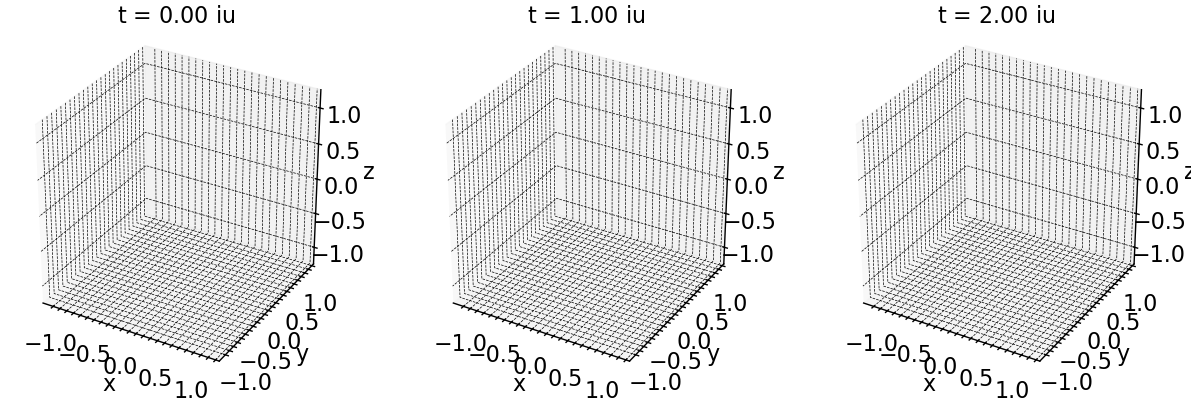

In [18]:
plt.rcParams['figure.figsize'] = [15 , 10]

fig, axes = plt.subplots(1, 3, subplot_kw={'projection':'3d'})

ax = axes[0]
ax.set_box_aspect([1, 1, 1])
ax.set_xlim(-1.2*R, 1.2*R)
ax.set_ylim(-1.2*R, 1.2*R)
ax.set_zlim(-1.2*R, 1.2*R)
ax.set_title(f't = ${time[0]:.2f}$ iu')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#for i in tqdm(range(len(x[:,]))):
#    if  i==4: ax.plot3D(x[i, 0], y[i, 0], z[i, 0], 'o', markersize=6*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='red')
#    ax.plot3D(x[i, 0], y[i, 0], z[i, 0], 'o', markersize=markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='deepskyblue', alpha=0.7)
    
ax = axes[1]
ax.set_box_aspect([1, 1, 1])
ax.set_xlim(-1.2*R, 1.2*R)
ax.set_ylim(-1.2*R, 1.2*R)
ax.set_zlim(-1.2*R, 1.2*R)
ax.set_title(f't = ${time[round(0.5*len(time))]:.2f}$ iu')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#for i in tqdm(range(len(x[:,]))):
#    ax.plot3D(x[i, np.argsort(time)[round(0.5*len(time))]], y[i, np.argsort(time)[round(0.5*len(time))]], z[i, np.argsort(time)[round(0.5*len(time))]], 'o', markersize=markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='deepskyblue', alpha=0.7)
    
ax = axes[2]
ax.set_box_aspect([1, 1, 1])
ax.set_xlim(-1.2*R, 1.2*R)
ax.set_ylim(-1.2*R, 1.2*R)
ax.set_zlim(-1.2*R, 1.2*R)
ax.set_title(f't = ${time[-1]:.2f}$ iu')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#for i in tqdm(range(len(x[:,]))):
#    ax.plot3D(x[i, -1], y[i, -1], z[i, -1], 'o', markersize=markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='deepskyblue', alpha=0.7)

# Animation

In [20]:
# if len(x)=N, then the animation will have N/k frames
k = 100

KeyboardInterrupt: 

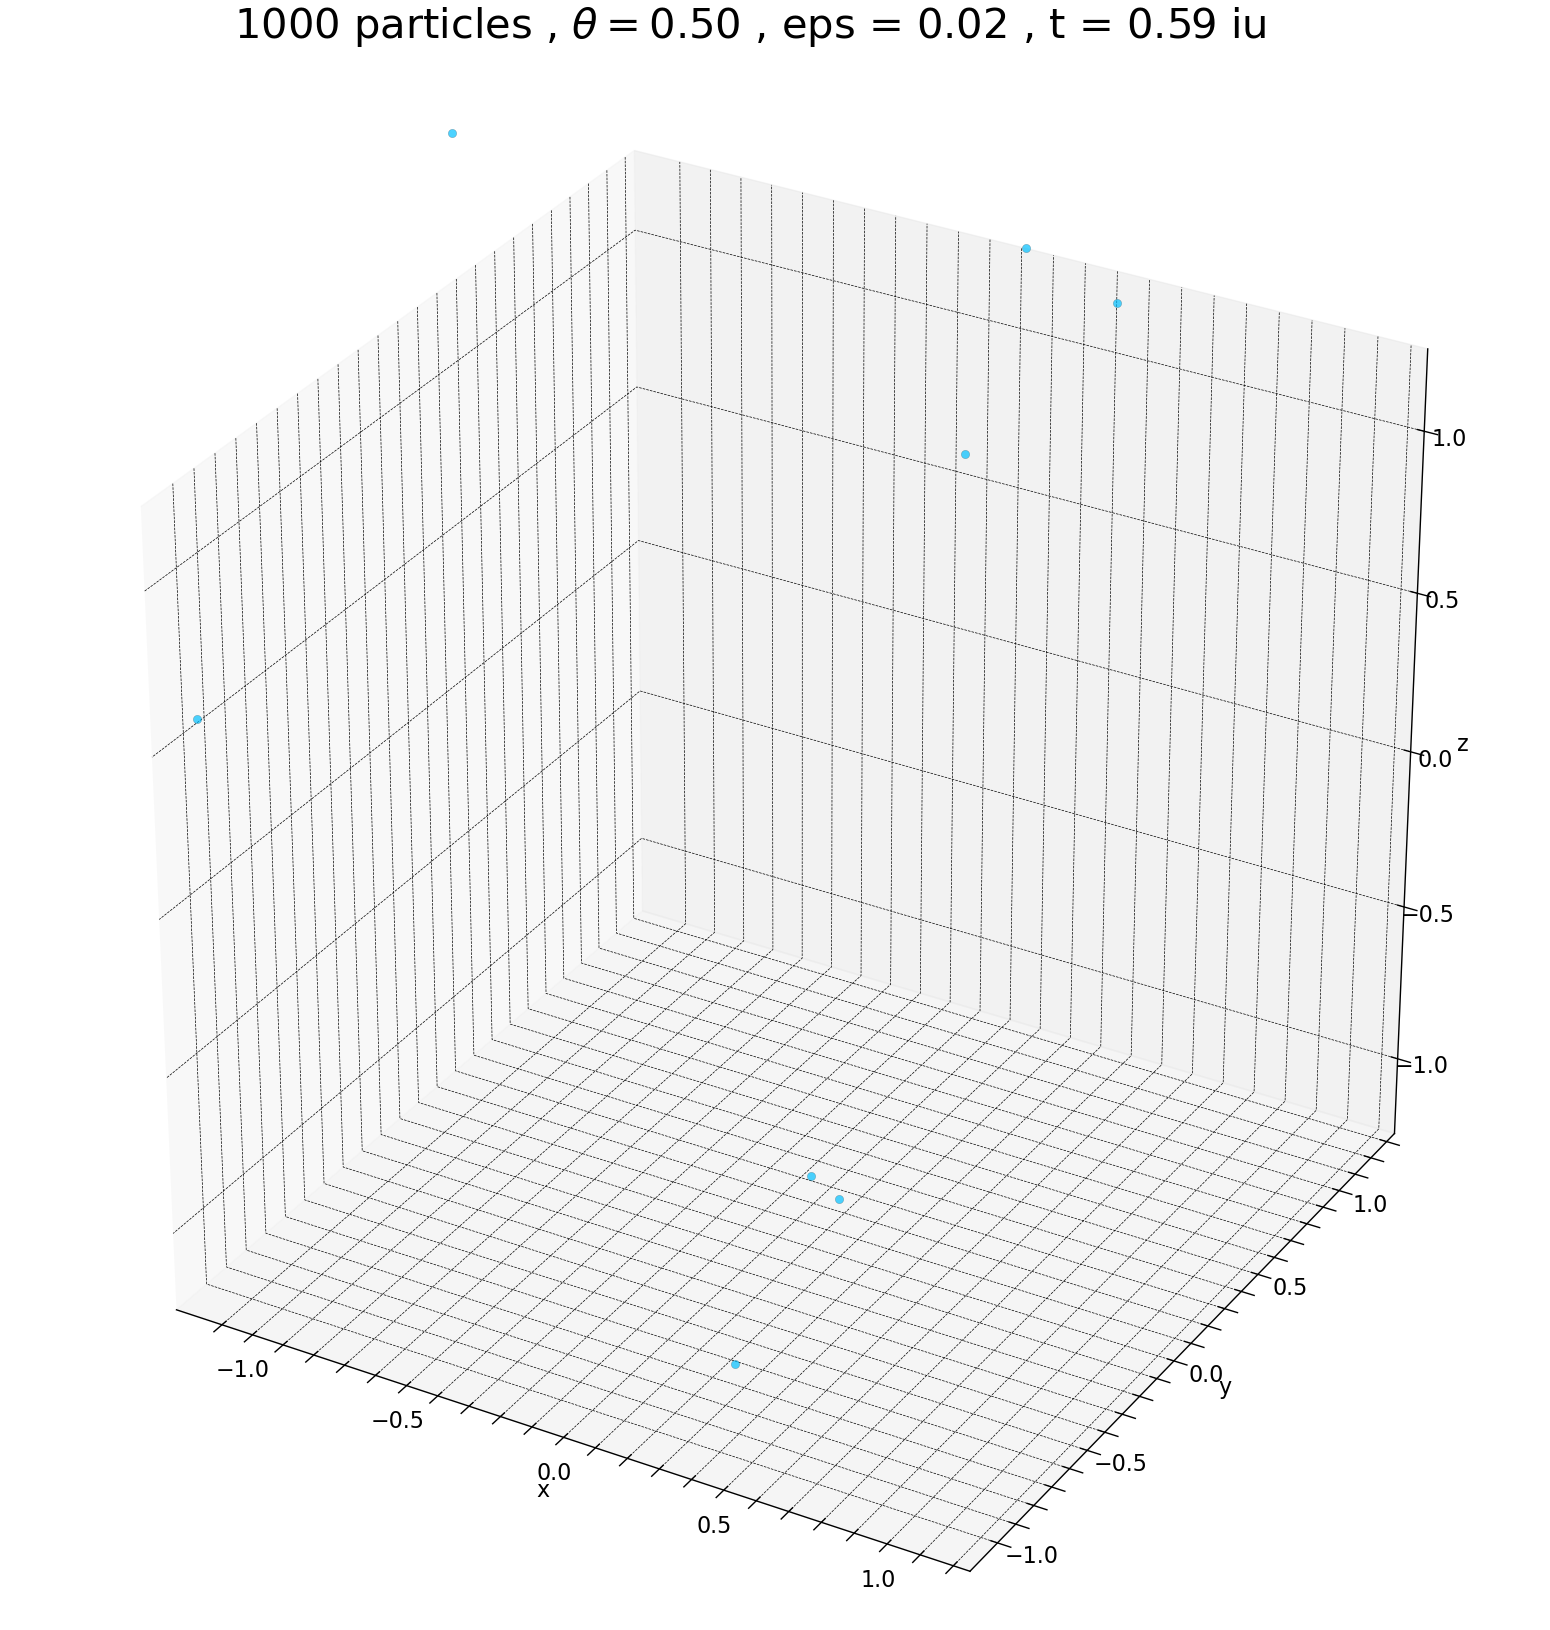

In [21]:
plt.rcParams['figure.figsize'] = [20 , 20]

#fig = plt.Figure() #somehow faster than fig, ax = plt.subplots(1,1), but text doesn't work well
#ax = fig.add_subplot()
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
ax = axes
title = fig.suptitle(f'{N} particles , $\\theta = {theta:.2f}$ , eps = ${eps:.2f}$ , t = ${time[0]:.2f}$ iu', fontsize=30, y=0.92)

def animate(i):
    print(math.ceil(100*i*k/len(x[0])), "%", end='\r')
    
    ax.clear()
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-1.2*R, 1.2*R)
    ax.set_ylim(-1.2*R, 1.2*R)
    ax.set_zlim(-1.2*R, 1.2*R)
    title.set_text(f'{N} particles , $\\theta = {theta:.2f}$ , eps = ${eps:.2f}$ , t = ${time[k*i]:.2f}$ iu')
    #ax.view_init(elev=30, azim=0.3*i)
    
    for j in range(len(x[:,])):
        #ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=10, markeredgecolor='black', markeredgewidth=0.5, color='deepskyblue', alpha=0.7)
        dist = Dist(x[j, 0], y[j, 0], z[j, 0], 0, 0, 0)
        #if  j==4: ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=6*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='red')
        if  dist > 0.66*R: ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=2*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='deepskyblue', alpha=0.7)
        elif (dist < 0.66*R and dist > 0.33*R): ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=2*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='lightgreen', alpha=0.7)
        else : ax.plot3D(x[j, k*i], y[j, k*i], z[j, k*i], 'o', markersize=2*markersize, markeredgecolor='black', markeredgewidth=markeredgewidth, color='orange', alpha=0.7)
    return fig,

writer = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, animate, frames=int(len(x[0])/k), interval=1, blit=True)
ani.save('sphere.gif', writer=writer, dpi=100)

#ani.save('sphere.mp4', writer=animation.FFMpegWriter(fps=40, bitrate=5000, codec='h264'), dpi=50)

# Radial distribution as a function of time

In [22]:
# Calculate radial distance from the origin for t in [0, T_collapse]
radial_distance = Dist(x, y, z, 0, 0 ,0)
radial_distance = radial_distance[:, :np.where(time==T_collapse)[0][0]]

# Define radial bins
r_bins = np.linspace(0, np.max(radial_distance), 40)

# Compute histogram of radial distances
hist = np.zeros([len(r_bins)-1, len(radial_distance[0, :])])

for i in range(len(radial_distance[0, :])):
    hist[:, i] = np.histogram(radial_distance[:, i], bins=r_bins)[0]

def Plot_Hist(t, r_bins, radial_distance):
    hist_plot = hist[:, t]
    
    plt.bar(r_bins[:-1], hist_plot, width=np.diff(r_bins), color='lightblue', edgecolor="black", align="edge", label='Data')
    
    r_max = np.max(radial_distance[:, t])
        
    plt.plot(r_bins, np.sum(np.diff(r_bins)*hist_plot) * 3*r_bins**2/r_max**3, color='red', label='Pdf for uniform density')
    plt.axvline(r_max, ls='--', color='black', label='Outer radius', zorder=0)
    plt.xlabel('Radial distance')
    plt.ylabel('Number of particles')
    plt.legend(loc='upper left')

In [23]:
# if len(x)=N, then the animation will have N/k frames
k = 1

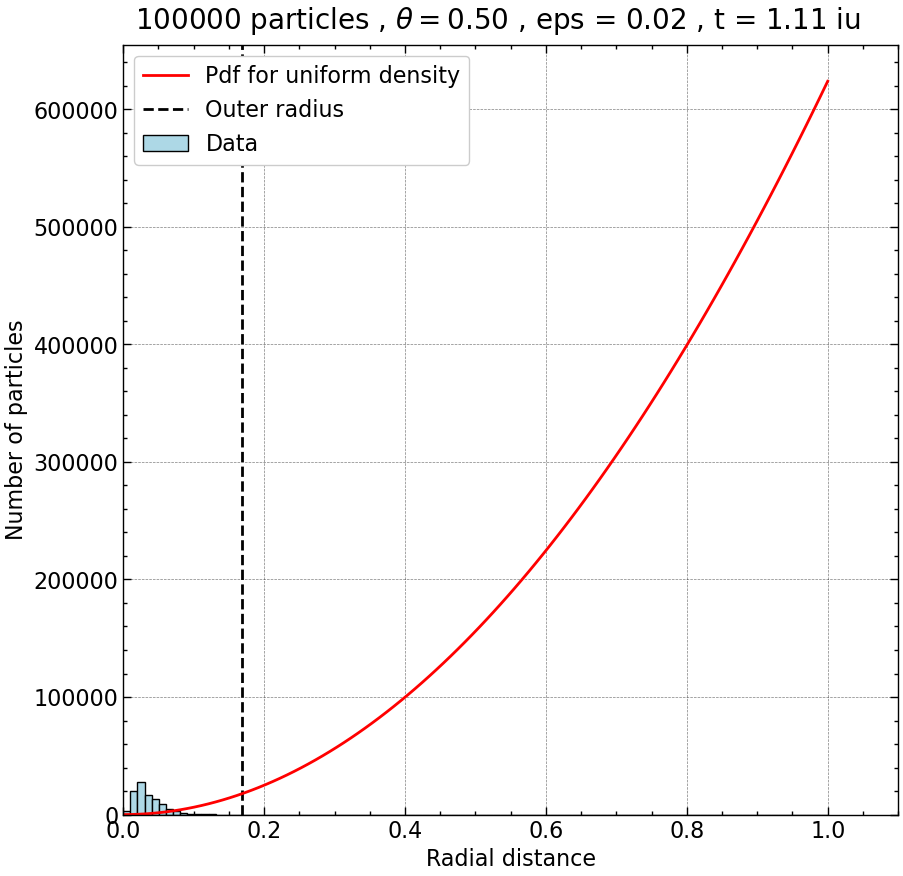

In [24]:
plt.rcParams['figure.figsize'] = [10 , 10]

fig, axes = plt.subplots(1, 1)
ax = axes
title = fig.suptitle(f'{N} particles , $\\theta = {theta:.2f}$ , eps = ${eps:.2f}$ , t = ${time[0]:.2f}$ iu', fontsize=20, y=0.92)

def animate(i):
    print(math.ceil(100*i*k/len(hist[0, :])), "%", end='\r')
    
    ax.clear()
    ax.set_xlim(0, 1.1*R)
    title.set_text(f'{N} particles , $\\theta = {theta:.2f}$ , eps = ${eps:.2f}$ , t = ${time[k*i]:.2f}$ iu')
    
    Plot_Hist(i, r_bins, radial_distance)
        
    return fig,

writer = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, animate, frames=int(len(hist[0, :])/k), interval=1, blit=True)
ani.save('histogram.gif', writer=writer, dpi=100)